<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC3
</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Recurrent Neural Networks

En esta práctica implementaremos redes neuronales recurrentes para generar música.

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

# Autor: Mario Ubierna San Mamés

# 0. Contexto y referencias

Esta PEC está basada en el siguiente [artículo de investigación](https://arxiv.org/pdf/1711.07682.pdf), aunque por motivos de extensión no podremos pasar por todos los puntos del artículo.

La primera etapa de esta PEC será leer y entender la idea general de este trabajo. El artículo os da acceso al código original con el que se ha llevado a cabo el trabajo y en el que además esta basado gran parte del código que aquí os adjuntamos, aunque por la complejidad y extensión del código no os recomendamos que sumergáis demasiado en él.

La PEC consta de una etapa de ***interpretación de los datos*** (un paso vital en todo proyecto real), donde se pedirá reproducir una gráfica del artículo. Luego ***entrenaremos*** una red LSTM para generar acordes a partir de archivos MIDI. Finalmente, usaremos la capa de ***embedding*** de la red entrenada para hacer una proyección de los acordes en 2D y visualizar el concepto de [word2vec](https://en.wikipedia.org/wiki/Word2vec).

Además de este fichero os hemos adjuntado un archivo comprimido con una estructura de datos similar a la usada en el artículo y que os recomendamos (por vuestro bien) que no modifiquéis :). Allí encontraréis una carpeta llamada *data* donde se encuentra la base de datos que usaremos y otros ficheros que os facilitamos con datos de redes ya entrenadas (en la carpeta *models*)

# 1. Procesado de datos [2.5 pts]

## 1.1 Importación de módulos y paquetes necesarios

In [1]:
!pip install pretty_midi==0.2.8

     |████████████████████████████████| 5.6 MB 5.3 MB/s 
     |████████████████████████████████| 51 kB 3.3 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.8-py3-none-any.whl size=5590821 sha256=03a7206e673f22b0c8191320bb1ce17a2e80c145e21180f1c0d86784d6cd951d
  Stored in directory: /root/.cache/pip/wheels/53/fd/dd/20e1b16dbcf028bbbd7f53b570bc3521183731cba4a73cb310
Successfully built pretty-midi


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# añade el path a tu directorio
#%cd /content/drive/MyDrive/UOC PACs/PAC3/
%cd /content/drive/MyDrive/PEC3_PAC3

/content/drive/MyDrive/PEC3_PAC3


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
import os
import sys
import pretty_midi as pm
import mido
from collections import Counter
import collections
import pandas as pd

importamos módulos propios (archivos .py) que podréis encontrar en la estructura de carpetas que os hemos facilitado

In [5]:
from settings import *
import midi_functions as mf 
import data_processing_functions as dpf

## 1.2 Ficheros MIDI [1 pt]

En esta sección vamos a entender un poco mejor la información que contiene un fichero MIDI y reproduciremos un archivo de nuestra base de datos. Para esta sección os recomendamos que le echéis un vistazo a la sección "*Extract notes*" del siguiente [tutorial de tensorflow](https://www.tensorflow.org/tutorials/audio/music_generation).

1.2.1 Escoger un fichero MIDI de la base de datos y crear las funciones necesarias para extraer las notas, el tiempo en que se toca cada nota, su duración y el momento en que se tocan. Este proceso se debe aplicar solo a un instrumento: **"Acoustic Grand Piano"**. 

*nota: Si el fichero escogido no tiene piano elegir otro fichero*

In [6]:
# Comprobamos si hay un archivo que tanga un solo instrumento y que éste sea Acoustic Grand Piano
data_directory = "/content/drive/MyDrive/PEC3_PAC3/data/original/"

for filename in os.listdir(data_directory):

  midifile = pm.PrettyMIDI(os.path.join(data_directory, filename))
  instruments = [pm.program_to_instrument_name(instrument.program) for instrument in midifile.instruments]

  if "Acoustic Grand Piano" in instruments and len(instruments) == 1:
    print("**************************************************************")
    print(filename)
    print("\n\tNúmero de instrumentos: " + str(len(midifile.instruments)))
    print("\tNúmero de instrumentos: " + str(instruments))
    print("**************************************************************\n\n")
    break

/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


**************************************************************
1ae49af2dc6cdb068d749b464f330441.mid

	Número de instrumentos: 1
	Número de instrumentos: ['Acoustic Grand Piano']
**************************************************************




In [7]:
# https://www.tensorflow.org/tutorials/audio/music_generation#extract_notes
# función obtenida del apartado "Extract notes"
def midi_to_notes(midifile):
  midi = pm.PrettyMIDI(midifile)
  instrument = midi.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['note'].append(pm.note_number_to_name(note.pitch))
    notes['start'].append(start)
    notes['end'].append(end)
    notes['duration'].append(end - start)
    notes['step'].append(start - prev_start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [8]:
df_piano = midi_to_notes(os.path.join(data_directory, "1ae49af2dc6cdb068d749b464f330441.mid"))
df_piano.head()

,pitch,note,start,end,duration,step
0,59,B3,1.750000,3.076969,1.326969,0.000000
1,56,G#3,2.807739,3.211585,0.403846,1.057739
2,64,E4,2.807739,3.942354,1.134615,0.000000
3,40,E2,2.807739,5.026399,2.218661,0.000000
4,59,B3,3.384662,3.798123,0.413461,0.576923


1.2.2 Modificar la funcion *plot_piano_roll* del tutorial para poder graficar el pianoroll de la canción MIDI escogida. En este caso deberemos poder indicar un tiempo máximo de la canción que queremos añadir en el pianoroll. Además, si pasamos un *max_time=-1*, se deberán graficar todas las notas de la canción

In [9]:
# https://www.tensorflow.org/tutorials/audio/music_generation#extract_notes
def plot_piano_roll(notes, max_time=-1):
  if max_time == -1:
    title = f'Canción entera'
    max_time = len(notes['pitch'])
  else:
    if max_time <= 0:
       title = f'Canción hasta el segundo 0'
       max_time = 0
    title = f'Canción hasta el segundo {max_time}'
    max_time = len(df_piano[df_piano["end"] <= max_time])

  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :max_time], plot_pitch[:, :max_time], color="b", marker=".")
  plt.xlabel('Tiempo [s]')
  plt.ylabel('Pitch (nota midi)')
  _ = plt.title(title)

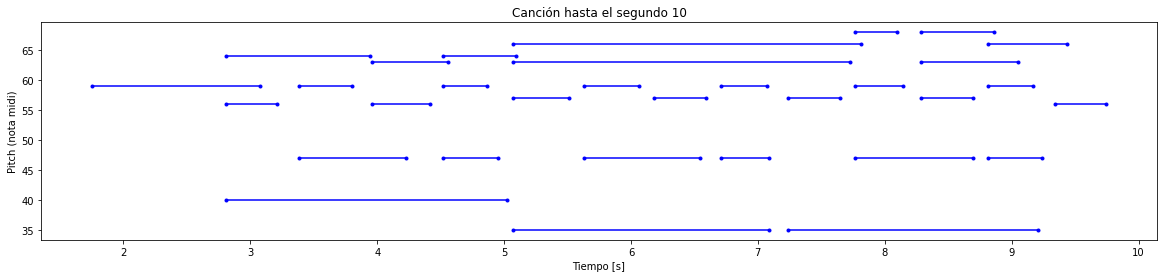

In [10]:
plot_piano_roll(df_piano, max_time=10)

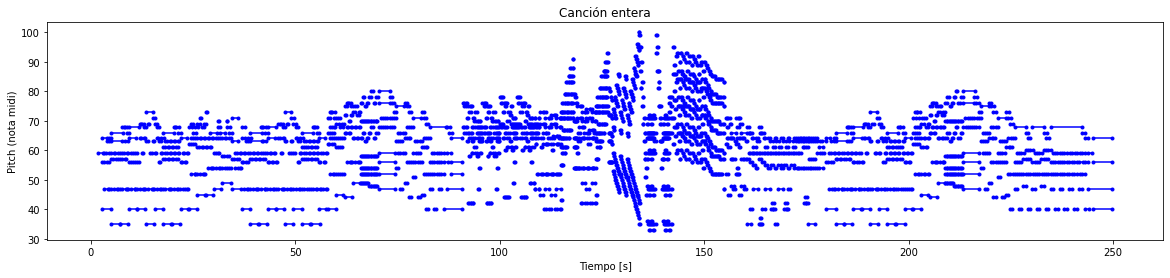

In [11]:
plot_piano_roll(df_piano, max_time=-1)

## 1.3 Procesado de datos [1.5 pts]

Ahora volvemos al artículo y aplicaremos el procesado de datos. Buscar dentro del fichero *data_processing_functions.py* la función que se encarga de llevar a cabo todo el procesado de datos y llamarla desde aquí

In [12]:
dpf.do_all_steps()

changing Tempo
histogramming
data/tempo/


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


make song histo
shifting midi files
making note indexes
histogramming
data/shifted/tempo/
extracting chords
getting dictionary
converting chords to index sequences
done


1.3.1 ¿Qué hace la función *change_tempo_folder*?¿Qué bpm fija para las canciones?

La función lo que hace es cambiar el tempo de los archivos midi originales, es decir, va recorriendo la carpeta `data/original` y cada archivo que encuentra genera un nuevo archivo y modifica el tempo correspondiente en la carpeta `data/tempo`.

El tempo que establece para cada canción es de `500000`. Realmente dicho valor no sé que significa, porque segundos no son, sin embargo, cuando ejecutamos el método `change_tempo_folder` lo que hace es reducir el tiempo de la canción, por lo que ese `new_msg.tempo = 500000` aumenta el tempo de cada pista que hay en el archivo midi.

1.3.2 Una vez tenemos ejecutado el procesado de datos se habrán creado muchas carpetas y muchos ficheros nuevos en la actual carpeta ***data***. Ahora usaremos algunos de estos ficheros para construir la figura 2 del artículo usando los datos procesados. Crearemos dos funciones:
*   my_save_histo_oct_from_midi_folder
*   my_midi_to_histo_oct

basadas en las funciones ***save_histo_oct_from_midi_folder*** y ***midi_to_histo_oct*** que encontraréis en los ficheros ***midi_functions.py*** y ***data_processing_functions.py***. Ahora las modificaremos para que nos devuelvan datos para dos tipos de histogramas: uno igual a la figura 2 del artículo (apariciones VS pitch) y otro, usando el *histo_oct*, que serán datos para graficar *apariciones VS notas en cualquier octava*, es decir, el número de veces que aparece una nota (sin importar a que octava pertenezca) a lo largo de una canción.


*indicación: Es importante entender la estructura de las variables:*
*   pianoroll
*   histo_bar
*   histo_oct

*dentro de la funcion* ***midi_to_histo_oct***

In [13]:
#usa este vector como labels del segundo gráfico 
notas_en_una_octava = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

In [14]:
def my_save_histo_oct_from_midi_folder(tempo_folder, histo_folder):
  lst_histo_bar = np.zeros(shape=128) # 128 es fijo por el número de pitches
  lst_histo_oct = np.zeros(shape=12) # 12 es fijo por el número de notas en una escala

  print(tempo_folder)
  nfiles=0
  for path, subdirs, files in os.walk(tempo_folder):
      for name in files:
          _path = path.replace('\\', '/') + '/'
          _name = name.replace('\\', '/')
          target_path = histo_folder+_path[len(tempo_folder):]
          if not os.path.exists(target_path):
              os.makedirs(target_path)
          try:
              nfiles+=1
              if nfiles%100==0:
                print("File #",nfiles,"Current file = ",_path,"/",_name) 
              
              # Recuperando los histogramas para cada canción
              histo_bar, histo_oct = my_midi_to_histo_oct(samples_per_bar,octave, fs, _name, _path, target_path)

              # Haciendo el sumatorio para cada canción y así cuando termine obtener el histograma final
              lst_histo_bar += np.sum(histo_bar, axis=1)
              lst_histo_oct += np.sum(histo_oct, axis=1)

          except (ValueError, EOFError, IndexError, OSError, KeyError, ZeroDivisionError) as e:
              exception_str = 'Unexpected error in ' + name  + ':\n', e, sys.exc_info()[0]
              print(exception_str)
    
  return lst_histo_bar, lst_histo_oct

def my_midi_to_histo_oct(samples_per_bar, octave, fs, name, path, histo_path):
  pianoroll = mf.get_pianoroll(name, path, fs)
  histo_bar = mf.pianoroll_to_histo_bar(pianoroll, samples_per_bar)
  histo_oct = mf.histo_bar_to_histo_oct(histo_bar, octave)

  return histo_bar, histo_oct

In [15]:
histo_bar, histo_oct = my_save_histo_oct_from_midi_folder(
    tempo_folder="/content/drive/MyDrive/PEC3_PAC3/data/tempo/",
    histo_folder="/content/drive/MyDrive/PEC3_PAC3/data/histo/"
)

/content/drive/MyDrive/PEC3_PAC3/data/tempo/


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


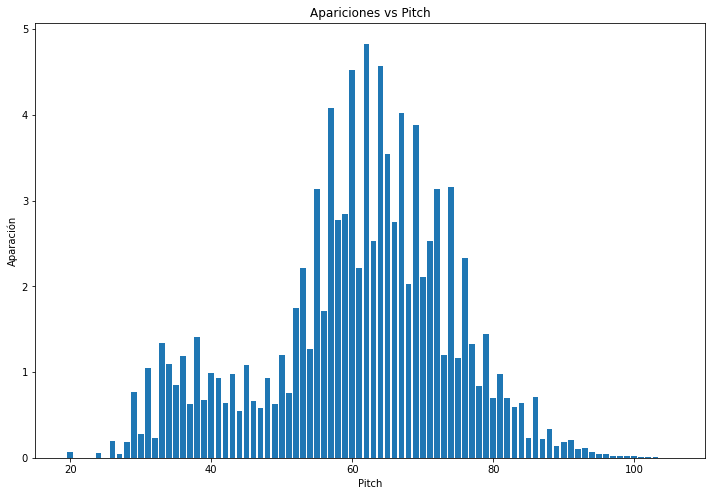

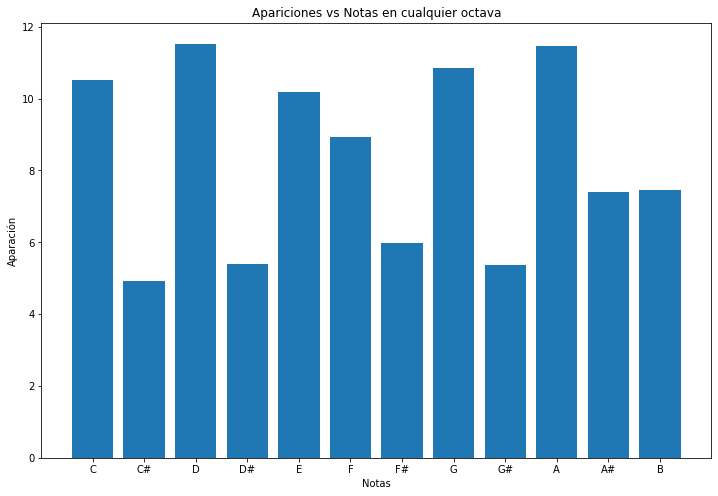

In [52]:
# Generamos los histogramas

# Histograma Aparaciones vs Pitch
histo_bar_fr = (histo_bar / np.sum(histo_bar)) * 100
fig, ax = plt.subplots(figsize=(12,8))
plt.bar(range(0,128), histo_bar_fr)
plt.xlim(15,110)
plt.title("Apariciones vs Pitch")
plt.xlabel("Pitch")
plt.ylabel("Aparación")
plt.show()

# Histograma Aparaciones vs Notas en cualquier octava
histo_oct_fr = (histo_oct / np.sum(histo_oct)) * 100
fig, ax = plt.subplots(figsize=(12,8))
plt.bar(notas_en_una_octava, histo_oct_fr)
plt.title("Apariciones vs Notas en cualquier octava")
plt.xlabel("Notas")
plt.ylabel("Aparación")
plt.show()

1.3.3 Buscar en internet sobre las escalas musicales e indicar que escala es la que más aparece en todas las canciones analizadas. ¿Cuáles dirías que son las notas más importantes de la escala?

#2. LSTM para acordes [5 pts]

El siguiente paso en el artículo es el entrenamiento de una red LSTM para la generación de acordes. Esta parte la haremos con un data set más pequeño y lo compararemos con resultados de entrenamientos previos que os faciliaremos. Primero cargamos la librerias que necesitaremos

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.layers import Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import keras.utils
from keras.utils import np_utils
from random import shuffle
import progressbar
import time

## 2.1 Carga de datos [0.5 pts]

2.1.1 En la carpeta ***data*** encontraréis un fichero llamado ***dataset.pkl*** que contiene 11338 canciones de train y 3780 de test. Usando *pickle* cargar los datos y luego separar 2000 para *train* y 500 canciones para *test* en las variables: 
*   train_set
*   test_set

crea además *train_set_size* y *test_set_size*

## 2.2 Modelo con una capa de ***Embedding*** [0.5 pts]

2.2.1 Ahora definiremos los parámetros de nuestra red LSTM usando los parámetros que dan en el artículo. El único cambio será en el tamaño de la red LSTM, en la que usaremos la mitad de la LSTM del artículo y número de epochs que usaremos 10 en nuestro caso

In [ ]:
batch_size = 1
step_size = 1
epochs = 10

#completar
lstm_size = 
learning_rate =
optimizer = 

El siguiente código es para mantener la estructura de carpetas que usan en el artículo ya que hay mucho código que depende de esta estructura:

In [ ]:
##--------NO TOCAR-------------------------------------------------------
base_path = 'models/chords/'
model_filetype = '.pickle'

shuffle_train_set = True
bidirectional = False

#Create model dir
fd = {'shifted': shifted, 'lr': learning_rate, 'emdim': chord_embedding_dim, 'opt': optimizer,
'bi': bidirectional, 'lstms': lstm_size, 'trainsize': train_set_size, 'testsize': test_set_size, 'samples_per_bar': samples_per_bar}
t = str(np.random.randint(1000,9999))
model_name = t+ '-Shifted_%(shifted)s_Lr_%(lr)s_EmDim_%(emdim)s_opt_%(opt)s_bi_%(bi)s_lstmsize_%(lstms)s_trainsize_%(trainsize)s_testsize_%(testsize)s_samples_per_bar%(samples_per_bar)s' % fd
model_path = base_path + model_name + '/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
##--------NO TOCAR-------------------------------------------------------


2.2.2 Finalmente definimos y compilamos la red con una capa de Embedding antes de la LSTM. Para este paso, acceder al código original del artículo y buscar en que fichero se entrena la LSTM copiar la estructura eliminando código que no es de nuestro interés

## 2.3 Entrenamiento [2 pts]

2.3.1 Siguiendo el código orginal del artículo donde se define la arquitectura de la LSTM para los acordes hay 3 funciones más:
*   test()
*   train()
*   save_params()

que nos serán de ayuda para el entrenamiento, testeo y para guardar los datos sobre el modelo entrenado. Guardaremos el valor de la ***loss*** tanto para test como para train cada 500 canciones, por lo que tendremos más de un punto por epoch. Modifica, si es necesario, las funciones *test()* y *train()* para que los ficheros de *total_test* y *total_train* dejen constancia de la epoch a la que pertenecen, esto te ayudará al graficar los datos más adelante.

Añade, antes de cada función una cabecera explicando brevemente lo que ésta hace.

---

*nota: comprueba que has definido todas las variables necesarias para que las* *funciones no den error en mitad del entrenamiento. Comienza usando menos datos* *para agilizar el proceso y una vez funcione todo usa el set completo*

In [ ]:
epoch_array=[]
total_test_loss_array = [] 
total_train_loss_array = []
total_test_loss = 0
show_plot = False
save_plot = False
test_step = 500
verbose = False
save_step = 1


#crea aquí las funciones test(), train() y save_params()

2.3.2 Responde las siguientes preguntas:
*  ¿Qué representa cada elemento de *X* en la función de *train()*?
*  ¿Qué se está usando como *label* para cada elemento de *X*? 
*  Justifica el uso de *categorical_crossentropy* como función de loss
*  ¿Qué crees que está aprendiendo la red?




 

2.3.3 Entrena la red usando las funciones anteriores

##2.4 Comparación de modelos [2 pts]

En este último paso compararemos diferentes modelos. En la carpeta *models/chords* encontrarás los datos (en un formato similar al generado anteriormente) del entrenamiento de modelos similares con otros parámetros:

1.   carpeta: 2717-Shifted_True_...
2.   carpeta: 5102-Shifted_True_...



2.4.1 Compara los 3 modelos: grafica las funciones de loss para train y test de cada modelo.

*   Indica los parámetros de cada uno de los 3 modelos (el que habéis entrenado y los 2 que os hemos dado)
*   ¿Qué set de parámetros ha dado la mejor performance?
*   ¿Se aprecia overfitting en alguno de los modelos? Justifica tu respuesta

# 3 Análisis de la capa de embedding [2 pts]

En esta sección recrearemos la figura 8 del artículo con la red que hemos entrenado y la que mejor performance nos ha dado en la comparación. 

In [ ]:
from keras.models import load_model
import keras
from keras import backend as K

## 3.1 Carga de modelos entrenados y generación de embeddings [1 pts]

3.1.1 Utiliza el *load_model* de **keras** para cargar:
*   el modelo que hemos entrenado: *my_model*
*   el modelo con mejor performance: *bp_model*


3.1.2 Ahora crearemos, para cada modelo, un nuevo modelo para los embedding. Para hacer esto, deberás crear un nuevo modelo cuya entrada sea igual a la entrada de los modelos originales y la salida sea el layer "embedding". Esto lo puedes hacer usando la función *get_layer()* del modelo.


3.1.3 El modelo de embedding recibe un acorde y devuelve un vector de 10 dimensiones con el embedding para cada acorde. Calcula estos vectores con cada uno de los modelos de embedding

3.1.4 Aplica un squeeze para eliminar los ejes de dimensión 1. El resultado de este squeeze debería ser (50,10)

## 3.2 Análisis PCA [1 pts]


Para acabar con nuestro análisis de los embeddings, vamos a realizar un proceso de PCA para reducir las dimensiones de los vectores resultantes y poder graficarlos en 2D.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

3.2.1 Escalar los vectores y aplicar PCA para reducir a 2 las dimensiones

3.2.2 Grafica para ambos embeddings los vectores en un scatterplot. Añadele anotaciones con las notas del acorde y comenta el resultado: ¿Observas el efecto word2vect en las gráficas?

Usa esta función para obtener un índice para los acordes y sus notas

In [ ]:
def get_chord_dict():
    chord_to_index = pickle.load(open(dict_path + chord_dict_name, 'rb'))
    index_to_chord = pickle.load(open(dict_path + index_dict_name, 'rb'))
    return chord_to_index, index_to_chord

chord_to_index, idx_2_chord = get_chord_dict()

3.2.3 Crea una función para calcular todas las distancias entre los primero 20 acordes. Luego haz una lista con las 10 distancias mínimas para ambos modelos. ¿Están relacionados estos acordes con distancias mínimas?

# 4. Rueda de 5tas (Bonus Track) [0.5 pts]

En este bonus track, y usando lo mismo que has usado para los apartados anteriores, podrás dibujar la rueda de quintas con datos entrenados sobre la misma base de datos, pero no hacer el shifteo de los acordes.

Usa los datos que encontrarás en la carpeta *models/chords/9671-Shifted_False...* para repetir el proceso del análisis de PCA

Una vez tienes los vectores, llama a las siguientes funciones para dibujar la rueda de quintas

In [ ]:
def get_chord_dict_no_shifted():
    chord_to_index = pickle.load(open('data/chord_dict.pickle', 'rb'))
    index_to_chord = pickle.load(open('data/index_dict.pickle', 'rb'))
    return chord_to_index, index_to_chord

chord_to_index_, idx_2_chord_ = get_chord_dict_no_shifted()

In [ ]:
ddd={tuple((0,4,7)):'C',
tuple((1,5,8)):'C#',
tuple((2,6,9)):'D',
tuple((3,7,10)):'D#',
tuple((4,8,11)):'E',
tuple((0,5,9)):'F',
tuple((1,6,10)):'F#',
tuple((2,7,11)):'G',
tuple((0,3,8)):'G#',
tuple((1,4,9)):'A',
tuple((2,5,10)):'A#',
tuple((3,6,11)):'B'}


def plot_5th_circle(X_chords_2d):
  
  fig, ax = plt.subplots()
  fig.set_size_inches(8, 6)

  plt.tick_params(labelsize=12)
  
  style = dict(size=12, color='black')

  for i in range(0,len(idx_2_chord_)):
    try:
      ax.text(-X_chords_2d[i,0]-0.32,X_chords_2d[i,1]+0.11, ddd[idx_2_chord_[i]],**style)
      ax.scatter(-X_chords_2d[i,0],X_chords_2d[i,1], c="blue", marker="*")
      
    except:
      pass

  plt.show()

In [ ]:
plot_5th_circle(my_embedd_pca) #pasa los vectores luego del análisis de PCA